# #1 Bollinger bands and RSI strategy
## Simplest, yet quite effective...
- Buy when it is at a discounted px (<= 2 sd) and oversold
- Sell when it is at a premium px (>= 2 sd) and overbought

In [43]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import talib
import XLML

Extract stocks prices

In [155]:
goog = yf.Ticker('NVR')

#get historical price (5 years)
df = goog.history(period="5y")
df = df.reset_index()

# Make date to pure date
df['Date'] = pd.to_datetime(df['Date']).dt.date
print(df)

            Date         Open         High          Low        Close  Volume   
0     2018-05-29  3024.000000  3086.000000  3001.000000  3085.949951   23700  \
1     2018-05-30  3090.000000  3103.739990  3027.409912  3058.100098   38200   
2     2018-05-31  3058.000000  3058.560059  2985.149902  2990.540039   31900   
3     2018-06-01  2996.120117  3061.360107  2996.120117  3035.360107   16300   
4     2018-06-04  3048.250000  3066.030029  3022.000000  3033.939941   22500   
...          ...          ...          ...          ...          ...     ...   
1253  2023-05-19  5860.229980  5889.979980  5771.910156  5846.520020   19000   
1254  2023-05-22  5845.000000  5899.430176  5705.319824  5705.319824   35600   
1255  2023-05-23  5663.120117  5688.529785  5589.600098  5611.290039   23900   
1256  2023-05-24  5609.000000  5668.560059  5566.790039  5585.700195   30300   
1257  2023-05-25  5591.259766  5689.029785  5591.259766  5635.220215   26400   

      Dividends  Stock Splits  
0      

In [156]:
print(df['Close'].rolling(30).mean())

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
           ...     
1253    5799.486361
1254    5807.001351
1255    5808.110693
1256    5807.960026
1257    5809.818359
Name: Close, Length: 1258, dtype: float64


USe TA-Lib for RSI and Bollinger bands

In [157]:
df['RSI'] = talib.RSI(df['Close'], timeperiod=14)
df['Bollinger High'], df['Mean'], df['Bollinger Low'] = talib.BBANDS(df['Close'], timeperiod=30, nbdevup=2, nbdevdn=2, matype=0)
print(df)

            Date         Open         High          Low        Close  Volume   
0     2018-05-29  3024.000000  3086.000000  3001.000000  3085.949951   23700  \
1     2018-05-30  3090.000000  3103.739990  3027.409912  3058.100098   38200   
2     2018-05-31  3058.000000  3058.560059  2985.149902  2990.540039   31900   
3     2018-06-01  2996.120117  3061.360107  2996.120117  3035.360107   16300   
4     2018-06-04  3048.250000  3066.030029  3022.000000  3033.939941   22500   
...          ...          ...          ...          ...          ...     ...   
1253  2023-05-19  5860.229980  5889.979980  5771.910156  5846.520020   19000   
1254  2023-05-22  5845.000000  5899.430176  5705.319824  5705.319824   35600   
1255  2023-05-23  5663.120117  5688.529785  5589.600098  5611.290039   23900   
1256  2023-05-24  5609.000000  5668.560059  5566.790039  5585.700195   30300   
1257  2023-05-25  5591.259766  5689.029785  5591.259766  5635.220215   26400   

      Dividends  Stock Splits        RS

Create corresponding strategy function to fit data and spot buy sell signals

In [158]:
def strategy(data):
    pos = 0
    buy_price = []
    sell_price = []
    for i in range(len(data)):
        if data['Close'][i] < data['Bollinger Low'][i] and data['RSI'][i] < 30 and pos == 0:
                buy_price.append(data['Close'][i])
                sell_price.append(np.nan)
                pos = 1
        elif data['Close'][i] > data['Bollinger High'][i] and data['RSI'][i] > 70 and pos == 1:
            sell_price.append(data['Close'][i])
            buy_price.append(np.nan)
            pos = 0
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
    return (buy_price, sell_price)
buy_price, sell_price = strategy(df)
df['Buy'] = buy_price
df['Sell'] = sell_price
print(df)

            Date         Open         High          Low        Close  Volume   
0     2018-05-29  3024.000000  3086.000000  3001.000000  3085.949951   23700  \
1     2018-05-30  3090.000000  3103.739990  3027.409912  3058.100098   38200   
2     2018-05-31  3058.000000  3058.560059  2985.149902  2990.540039   31900   
3     2018-06-01  2996.120117  3061.360107  2996.120117  3035.360107   16300   
4     2018-06-04  3048.250000  3066.030029  3022.000000  3033.939941   22500   
...          ...          ...          ...          ...          ...     ...   
1253  2023-05-19  5860.229980  5889.979980  5771.910156  5846.520020   19000   
1254  2023-05-22  5845.000000  5899.430176  5705.319824  5705.319824   35600   
1255  2023-05-23  5663.120117  5688.529785  5589.600098  5611.290039   23900   
1256  2023-05-24  5609.000000  5668.560059  5566.790039  5585.700195   30300   
1257  2023-05-25  5591.259766  5689.029785  5591.259766  5635.220215   26400   

      Dividends  Stock Splits        RS

Generate PnL reports on results

In [159]:
#PnL results
buy_signals = df['Buy'].dropna().reset_index(drop=True)
sell_signals = df['Sell'].dropna().reset_index(drop=True)
pnl = sell_signals - buy_signals
accruacy = pnl[pnl>0].sum()/abs(pnl).sum()
print('Accruacy (pro-rata): ', accruacy)
print('Total PnL: ', pnl.sum())
print('PnL record in pair:\n', pnl)

Accruacy (pro-rata):  1.0
Total PnL:  1940.77001953125
PnL record in pair:
 0    520.750000
1    786.600098
2    633.419922
dtype: float64


Time horizon per average investment pair (buy & sell)

In [160]:
buy_days = df['Date'][df['Buy'].notna()].reset_index(drop=True)
sell_days = df['Date'][df['Sell'].notna()].reset_index(drop=True)
print('Buy days:\n', buy_days)
print('Sell days:\n', sell_days)
trade_duration = sell_days - buy_days
# transfrom trade_duration to numbers
trade_duration = trade_duration.apply(lambda x: x.days)
print('Trade duration: ', trade_duration)
print('Average trade duration: ', trade_duration.mean())

Buy days:
 0    2018-10-03
1    2020-03-12
2    2022-02-23
Name: Date, dtype: object
Sell days:
 0    2019-04-11
1    2020-07-22
2    2023-01-31
Name: Date, dtype: object
Trade duration:  0    190
1    132
2    342
Name: Date, dtype: int64
Average trade duration:  221.33333333333334


Visualise strategy

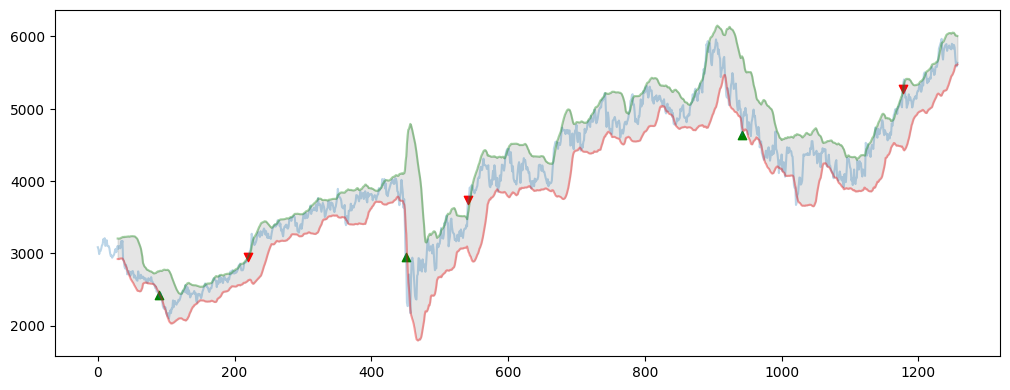

<Figure size 1220x450 with 0 Axes>

<Figure size 1220x450 with 0 Axes>

In [161]:
# Scale the plot size larger to be easier to see, now too packed
plt.figure(figsize=(12.2, 4.5))

plt.plot(df['Close'], label='Close', alpha = 0.3)
plt.plot(df['Bollinger High'], label='Bollinger High', color='green', alpha=0.35)
plt.plot(df['Bollinger Low'], label='Bollinger Low', color='red', alpha=0.35)
plt.fill_between(df.index, df['Bollinger High'], df['Bollinger Low'], color='grey', alpha=0.2)
plt.scatter(df.index, df['Buy'], label='Buy', marker='^', color='green')
plt.scatter(df.index, df['Sell'], label='Sell', marker='v', color='red')
plt.show()

# Scale the plot size larger to be easier to see, now too packed
plt.figure(figsize=(12.2, 4.5))

## Testing the strategy with S&P500 companies

In [162]:
from concurrent.futures import ThreadPoolExecutor

In [163]:
# create a dataframe to extract snp500 companies list
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
df_temp = pd.read_html(url)[0]
stock_list = df_temp['Symbol'].to_list()

Extract historical data from yfinance

In [164]:
stocks = yf.Tickers(stock_list).history(period="5y")

[*********************100%***********************]  503 of 503 completed

5 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- BALL: No data found for this date range, symbol may be delisted
- BRK.B: No data found, symbol may be delisted
- CVX: No data found for this date range, symbol may be delisted
- NSC: No data found for this date range, symbol may be delisted


Perform data cleansing

In [165]:
df2 = stocks.reset_index()['Close']
df2 = df2.dropna(axis=1, how='all')

Create loops with thread pool executor to concurrently run tickers extraction

In [166]:
def process_ticker(ticker):
    df = yf.Ticker(ticker).history(period="5y").reset_index()
    df['RSI'] = talib.RSI(df['Close'], timeperiod=14)
    df['Bollinger High'], df['Mean'], df['Bollinger Low'] = talib.BBANDS(df['Close'], timeperiod=30, nbdevup=2, nbdevdn=2, matype=0)
    buy_price, sell_price = strategy(df)
    df['Buy'] = buy_price
    df['Sell'] = sell_price
    buy_signals = df['Buy'].dropna().reset_index(drop=True)
    sell_signals = df['Sell'].dropna().reset_index(drop=True)
    pnl = sell_signals - buy_signals
    accuracy = pnl[pnl > 0].sum() / abs(pnl).sum()
    return ticker, accuracy, pnl.sum()

tickers = df2.columns

with ThreadPoolExecutor() as executor:
    results = list(executor.map(process_ticker, tickers))

results_dict = {}
for ticker, accuracy, pnl in results:
    results_dict[ticker] = {'accuracy': accuracy, 'pnl': pnl}

/var/folders/gb/y91d_0014dlgwfxhcglf4drc0000gn/T/ipykernel_1882/1224187693.py:11: RuntimeWarning: invalid value encountered in scalar divide
  accuracy = pnl[pnl > 0].sum() / abs(pnl).sum()


Store the dictionary into dataframes for better visibilities

In [167]:
backtests = pd.DataFrame(results_dict).from_dict(results_dict, orient='index')
print(backtests)

      accuracy        pnl
A     0.960257  42.135498
AAL   0.495022  -0.218626
AAP   0.868762  22.983688
AAPL  1.000000  47.603046
ABBV  0.946477  67.670731
...        ...        ...
YUM   0.990837  21.433937
ZBH   0.775372  37.520622
ZBRA  0.595930  75.510040
ZION  0.724930  12.270226
ZTS   1.000000  84.508667

[498 rows x 2 columns]


<Axes: >

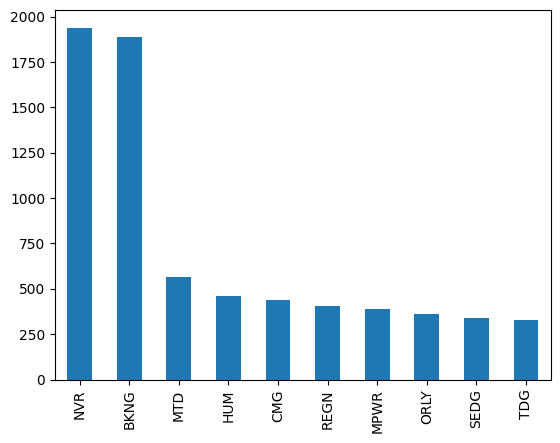

In [168]:
backtests['pnl'].sort_values(ascending=False).head(10).plot(kind='bar')

<Axes: >

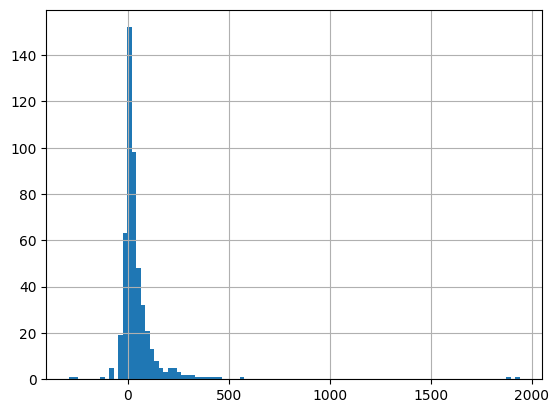

In [169]:
backtests['pnl'].hist(bins=100)